In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vector
import copy
import math
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [259]:
class Simulation:
    def __init__(self,length,initial_particle_x,initial_particle_y,initial_particle_z):
        self.max_displacement = length/2 #(m)
        self.min_displacement = -length/2 #(m)
        self.time_passed = 0 #(s)
        self.boltzmann_constant = 1.38*10**-23
        self.argon_mass = 6.63*10**-26 #(kg)
        self.instantaneous_del_momentum_x_positive = 0 #(kgm/s)
        self.totalDelMomentum_x_positive = 0 #(kgm/s)
        self.stateSnapshots = []
        self.times = []
        self.temperatures = []
        self.pressures = []
        self.current_x = copy.copy(initial_particle_x)
        self.current_y = copy.copy(initial_particle_y)
        self.current_z = copy.copy(initial_particle_z)
        self.current_v_x = np.zeros(len(initial_particle_x))
        self.current_v_y = np.zeros(len(initial_particle_x))
        self.current_v_z = np.zeros(len(initial_particle_x))
        self.current_a_x = np.zeros(len(initial_particle_x))
        self.current_a_y = np.zeros(len(initial_particle_x))
        self.current_a_z = np.zeros(len(initial_particle_x))

        self.particles_x = [copy.copy(initial_particle_x)]
        self.particles_y = [copy.copy(initial_particle_y)]
        self.particles_z = [copy.copy(initial_particle_z)]
        self.particles_v_x = [np.zeros(len(initial_particle_x))]
        self.particles_v_y = [np.zeros(len(initial_particle_x))]
        self.particles_v_z = [np.zeros(len(initial_particle_x))]
        self.particles_a_x = [np.zeros(len(initial_particle_x))]
        self.particles_a_y = [np.zeros(len(initial_particle_x))]
        self.particles_a_z = [np.zeros(len(initial_particle_x))]


   

    def update_acceleration(self):
        #Argon parameters
        sigma = 0.3345*10**-9 #m
        epsilon = 1.735*10**-21
        argon_mass = 6.63*10**-26 #kg
        for i in range(0,len(self.current_x)):
            #Instantiatet the force vector acting upon i from all other possible particles j_n
            vec_force_i  = np.asarray([0,0,0])
            for j in range(0,len(self.current_x)):
                if (i == j):
                    continue
                r_i = np.asarray([self.current_x[i],self.current_y[i],self.current_z[i]])
                r_j = np.asarray([self.current_x[j],self.current_y[j],self.current_z[j]])
                #Considering the position vector from particle j to i
                r_ji = r_i - r_j
                r_ji_mag = math.sqrt(abs(np.dot(r_ji,r_ji)))
                r_ji_direction = r_ji/r_ji_mag

                #Force eqn below from radial distance derivative of Lennard-Jones potential
                try:
                    if (r_ji_mag**13 != 0):
                        mag_force = (24*epsilon*sigma**6*(r_ji_mag**6-2*sigma**6))/(r_ji_mag**13)
                    else:
                        mag_force = 0
                    vec_force_ji = mag_force*r_ji_direction
                    vec_force_i = vec_force_i + vec_force_ji
                    vec_acc_i = vec_force_i/argon_mass
                except:
                    vec_acc_i = np.asarray[0,0,0]
                # vec_force_i =  vec_force_ji

            #Finally we have spatial acceleration vector
            if (r_ji_mag**13 != 0):
                # print(vec_acc_i[0])
                self.current_a_x[i] = vec_acc_i[0]
                self.current_a_y[i] = vec_acc_i[1]
                self.current_a_z[i] = vec_acc_i[2]
            else:
                self.current_a_x[i] = 0
                self.current_a_y[i] = 0
                self.current_a_z[i] = 0
            

    def update_velocity(self,dt=0.00001):
        acceleration = np.asarray([self.current_a_x,self.current_a_y,self.current_a_z])
        velocity = np.asarray([self.current_v_x,self.current_v_y,self.current_v_z])
        velocity = velocity + (dt/2)*acceleration
        self.current_v_x = velocity[0]
        self.current_v_y = velocity[1]
        self.current_v_z = velocity[2]

            
    def update_position(self,dt=0.00001):
        self.instantaneous_del_momentum_x_positive = 0
        for i in range(0,len(self.current_x)):
            position = np.asarray([self.current_x[i],self.current_y[i],self.current_z[i]])
            # print('position before')
            # print(position)
            velocity = np.asarray([self.current_v_x[i],self.current_v_y[i],self.current_v_z[i]])
            # print('del positiion')
            # print(dt*velocity)
            position = position + (dt)*velocity
            # print('position after')
            # print(position)
            #In +ve x direction:
            if (position[0] > self.max_displacement): #if a particle has passed 'tried' to pass the boundary 
                # print('triggered')
                #Place the particle at the boundary
                position[0] = self.max_displacement
                #Increment the total del_momentum in x for future momentum calculation
                self.instantaneous_del_momentum_x_positive += self.argon_mass*math.sqrt(abs(np.dot(velocity,velocity)))
                self.totalDelMomentum_x_positive += self.argon_mass*math.sqrt(abs(np.dot(velocity,velocity)))
                #Reverse its momentum in relevant direction to simulate an elastic collision
                velocity[0] = -1*velocity[0]
            #in -ve x direction:
            elif(position[0] < self.min_displacement):
                #Place the particle at the boundary
                position[0] = self.min_displacement
                #We will not consider del momentum for any other directions, since principle of pressure symmetry should
                #allow us to calculate total pressure from total del momentum using one sign of one axis.
                velocity[0] = -1*velocity[0]
            #On y axis:
            if (position[1] > self.max_displacement): 
                position[1] = self.max_displacement
                velocity[1] = -1*velocity[1]
            elif(position[1] < self.min_displacement):
                position[1] = self.min_displacement
                velocity[1] = -1*velocity[1]
            #On z axis:
            if (position[2] > self.max_displacement): 
                position[2] = self.max_displacement
                velocity[2] = -1*velocity[2]
            elif(position[1] < self.min_displacement):
                position[2] = self.min_displacement
                velocity[2] = -1*velocity[2]

            self.current_x[i] = position[0]
            self.current_y[i] = position[1]
            self.current_z[i] = position[2]
            self.current_v_x[i] = velocity[0]
            self.current_v_y[i] = velocity[1]
            self.current_v_z[i] = velocity[2]
    

    def capture_state(self):
       
        self.particles_x.append(copy.copy(self.current_x))
        self.particles_y.append(self.current_y)
        self.particles_z.append(self.current_z)

        self.particles_v_x.append(self.current_v_x)
        self.particles_v_y.append(self.current_v_y)
        self.particles_v_z.append(self.current_v_z)

        self.particles_a_x.append(self.current_a_x)
        self.particles_a_y.append(self.current_a_y)
        self.particles_a_z.append(self.current_a_z)
        

    def calculate_instantaneous_pressure(self,delt):
        face_area = (self.max_displacement*2)**2
        p_x_instantaneous = (1/(face_area*delt))*self.instantaneous_del_momentum_x_positive
        pressure_instantaneous = 3*p_x_instantaneous 
        self.pressures.append(pressure_instantaneous)
        return pressure_instantaneous

    def calculate_average_pressure(self,delt):
        face_area = (self.max_displacement*2)**2
        total_time = delt*len(self.stateSnapshots)
        p_x_average = (1/(face_area*total_time))*self.totalDelMomentum_x_positive
        presure_average = 3*p_x_average
        return presure_average

    # def calculate_temperature(self):
    #     # Temperature related to total KE of a gas
    #     particle_state = self.capture_state()
    #     N_particles = len(particle_state)
    #     KE = 0
    #     for particle in particle_state:
    #         # Calculate magnitude velocity 
    #         vel_mag = math.sqrt(particle.velocity.x**2+particle.velocity.y**2+particle.velocity.z**2)
    #         KE+= 0.5*self.argon_mass*vel_mag
    #     temperature = KE*(0.666)/(N_particles*self.boltzmann_constant)
    #     self.temperatures.append(temperature)
    #     return temperature

    def main(self,delt = 0.00001,nSteps=100,maxTime=0,render = False):
        time=0
        self.times = [0]
    
        if (maxTime == 0):
            maxTime = nSteps*delt
        while (time <= maxTime):

            self.update_acceleration()
            self.update_velocity(dt = delt)
            self.update_position(dt = delt)
            self.capture_state()
            self.times.append(time+delt)
            # self.particles = currentState
            time = time+delt
        




Task 1 Testing

In [ ]:
sigma = 0.3345*10**-9 #m
initial_x = [0.0,7*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]

sim1 = Simulation(length= 100*sigma,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
sim1.main(delt=1e-10)

xCoords = sim1.particles_x
xCoords = np.transpose(xCoords)
xVelCoords = sim1.particles_v_x
xVelCoords = np.transpose(xVelCoords)
times = sim1.times


In [ ]:
fig,ax = plt.subplots()
ylim = [-100*sigma/2,50*sigma]
ax.set_ylim(ylim)
ax.scatter(sim1.times,xCoords[0])
ax.scatter(sim1.times,xCoords[1])
np.shape(xVelCoords[0])

Task 2 Particles in a box

In [260]:
sigma = 0.3345*10**-9 #m
length = 20*sigma
initial_x = [-2*sigma,2*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]

sim2 = Simulation(length= length,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
sim2.main(delt=1e-10,nSteps=1000)

xCoords = sim2.particles_x
xCoords = np.transpose(xCoords)
yCoords = sim2.particles_y
yCoords = np.transpose(yCoords)
zCoords = sim2.particles_z
zCoords = np.transpose(zCoords)

xVelCoords = sim2.particles_v_x
xVelCoords = np.transpose(xVelCoords)
xAccCoords = sim2.particles_a_x
xVelCoords = np.transpose(xVelCoords)

times = sim2.times


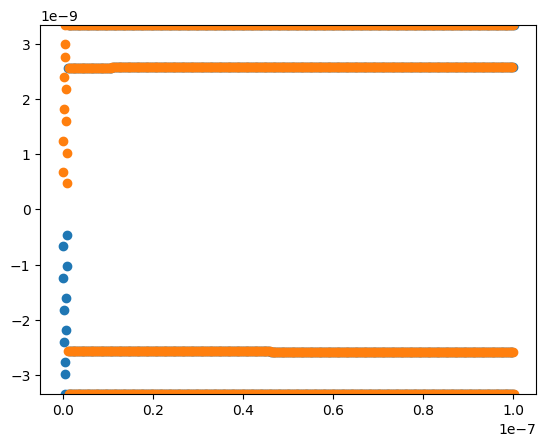

In [261]:
fig,ax=plt.subplots()
ylim = [-length/2,length/2]
ax.set_ylim(ylim)

xTranspose = np.transpose(sim2.particles_x)
ax.scatter(sim2.times,xTranspose[0])
ax.scatter(sim2.times,xTranspose[1])


Task 3 - Investigate
Before proceeding it will be best to visualize & animate the simulation

In [262]:
sigma = 0.3345*10**-9 #m
length = 20*sigma
initial_x = [-2*sigma,2*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]
zCoords = sim2.particles_z

sim2 = Simulation(length=length,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
sim2.main(delt=1e-11,nSteps=1000)
xCoords = sim2.particles_x
yCoords = sim2.particles_y
zCoords = sim2.particles_z


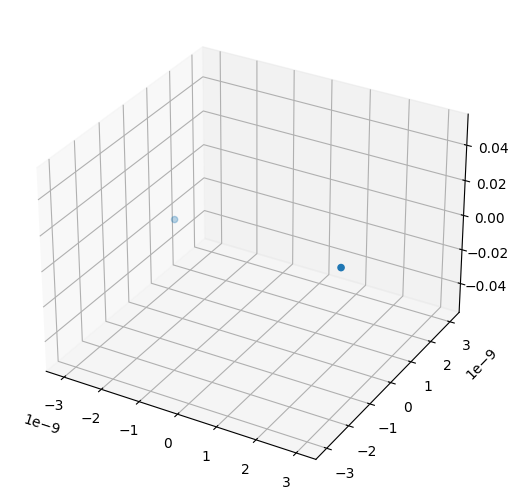

In [263]:

fig = plt.figure()
xlim = [-length/2,length/2]
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(xlim)
# ax.set_zlim(xlim)

def update_points(num):
    num = 10*num
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords[num],yCoords[num],zCoords[num])
# index = 3
# ax.scatter(xs=xCoords[index],ys=yCoords[index],zs=zCoords[index])
    # return fig,ax
graph = ax.scatter(xs=xCoords[0],ys=yCoords[0],zs=zCoords[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,len(xCoords)),repeat=False)
anim.save('test_gif.gif')


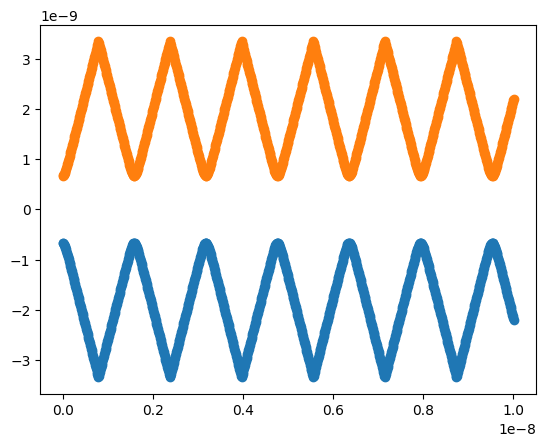

In [264]:
fig,ax = plt.subplots()
xTranspose = np.transpose(sim2.particles_x)
ax.scatter(sim2.times,xTranspose[0])
ax.scatter(sim2.times,xTranspose[1])

In [267]:
box_length = 20*sigma
sim3_initial_x = []
sim3_initial_y = []
sim3_initial_z = []
for i in range(-2,3):
    for j in range(-2,3):
        for k in range(-2,3):
            sim3_initial_x.append(i*sigma)
            sim3_initial_y.append(j*sigma)
            sim3_initial_z.append(k*sigma)

sim3 = Simulation(length=box_length,initial_particle_x=sim3_initial_x,initial_particle_y=sim3_initial_y,initial_particle_z=sim3_initial_z)


Introducing a change of unit
All lengths mentioned are no longer meters but are sigma meters
1(SM) = 0.3*10-9 meters

In [268]:
sim3.main(delt=1e-10,nSteps=1000)


/tmp/ipykernel_24569/3370756948.py:53: RuntimeWarning: invalid value encountered in true_divide
  r_ji_direction = r_ji/r_ji_mag


OverflowError: (34, 'Numerical result out of range')

In [ ]:
fig = plt.figure()
xlim = [-box_length/2,box_length/2]
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(xlim)
# ax.set_zlim(xlim)

def update_points(num):
    num = 10*num
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords[num],yCoords[num],zCoords[num])
# index = 3
# ax.scatter(xs=xCoords[index],ys=yCoords[index],zs=zCoords[index])
    # return fig,ax
graph = ax.scatter(xs=xCoords[0],ys=yCoords[0],zs=zCoords[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,len(xCoords)),repeat=False)
anim.save('test_gif.gif')
